# En France, le député assidu présente-t-il un profil type ? 

Alors que la société française se caractérise par une grande défiance de la population vis-à-vis de ses élus et responsables politiques, nous nous pencherons dans ce projet sur la question de l'assiduité des députés au cours de leur mandat. Nous verrons notamment grâce à différents outils (boîtes de Tukey, matrice de nuages de points, analyse en composantes principales, clustering, régression linéaire...) si l'on peut dresser un portrait type pour caractériser le député assidu ou absentéiste. 

In [1]:
%matplotlib widget

import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import seaborn as sns

## I. Récupération et préparation des données

### 1. Importation des données

#### 1.1 Récupération de la base de données principale

On récupère sur le site citoyen nosdeputes.fr une base de données synthétisant l'activité parlementaire sur les 12 derniers mois. Pour chaque député, cette table, que nous avons convertie au format .tsv, contient des informations relatives à son état civil, à la circonscription dont il est le représentant, à son éventuel parti politique et surtout à son travail parlementaire (semaines de présence à l'Assemblée nationale, rédaction de rapports, participation à des commissions...).

In [2]:
# Conversion du fichier tsv en DataFrame.
df = pd.read_csv("../Données/nosdeputes.fr_synthese_2020-10-24.tsv", sep='\t')
df

,id,nom,nom_de_famille,prenom,sexe,date_naissance,lieu_naissance,num_deptmt,nom_circo,num_circo,...,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales
0,32,Damien Abad,Abad,Damien,H,1980-04-05,Nîmes (Gard),01,Ain,5,...,253,307,19,1736,63,0,0,25,38,9
1,43,Caroline Abadie,Abadie,Caroline,F,1976-09-07,Saint-Martin-d'Hères (Isère),38,Isère,8,...,17,8,14,362,196,0,0,3,3,0
2,493,Jean-Félix Acquaviva,Acquaviva,Jean-Félix,H,1973-03-19,Bastia (Haute-Corse),2B,Haute-Corse,2,...,109,9,186,2309,89,0,0,4,22,3
3,152,Lénaïck Adam,Adam,Lénaïck,H,1992-02-19,Saint Laurent du Maroni (Guyane),973,Guyane,2,...,3,0,15,581,175,0,0,4,1,0
4,234,Damien Adam,Adam,Damien,H,1989-06-28,Orléans (Loiret),76,Seine-Maritime,1,...,24,7,74,687,225,0,0,4,10,2
5,135,Saïd Ahamada,Ahamada,Saïd,H,1972-11-07,Saint-Denis (Réunion),13,Bouches-du-Rhône,7,...,8,1,14,394,200,0,0,4,0,1
6,508,Éric Alauzet,Alauzet,Éric,H,1958-06-07,Nancy (Meurthe-et-Moselle),25,Doubs,2,...,3,1,14,541,191,0,0,4,19,0
7,183,Ramlati Ali,Ali,Ramlati,F,1961-05-28,Pamandzi (Mayotte),976,Mayotte,1,...,5,2,18,485,163,0,0,3,2,4
8,499,Aude Amadou,Amadou,Aude,F,1980-02-29,Coutances (Manche),44,Loire-Atlantique,4,...,2,1,8,334,144,0,0,3,0,0
9,382,Patrice Anato,Anato,Patrice,H,1976-03-14,Lomé (Togo),93,Seine-Saint-Denis,3,...,5,0,16,574,197,1,0,4,16,2


#### 1.2 Complétion de la base de données à l'aide de webscraping

Ce jeu de données est plutôt complet, mais il lui manque une variable qui pourrait nous intéresser pour notre étude : le statut du député (sortant, élu pour la première fois, ancien député ou arrivé en cours de mandat).

Nous allons donc compléter la table avec la variable "statut" du tableau disponible sur la page http://www2.assemblee-nationale.fr/elections/liste/2017/resultats/RESULTAT.

In [3]:
# On récupère le code source de la page afin d'en extraire le tableau.
from urllib import request
import bs4

request_text = request.urlopen("http://www2.assemblee-nationale.fr/elections/liste/2017/resultats/RESULTAT").read()
page = bs4.BeautifulSoup(request_text, "html")
tableau_html = page.find("table") # On extrait le tableau d'intérêt de la page HTML.

Nous avons récupéré le code HTML du tableau, récupérons maintenant ses entêtes.

In [4]:
entetes = tableau_html.find('thead')
entetes = entetes.find('tr')
entetes = entetes.find_all('th')
entetes = [entete.text.strip() for entete in entetes]
print(entetes)

['Civ.', 'Nom', 'Prénom', 'Département', 'Circ.', 'Statut', 'Tour', 'Nuance']


Puis complétons un dictionnaire avec ses lignes et transformons le en DataFrame.

In [5]:
dict_tableau = {}
for entete in entetes:
    dict_tableau[entete] = []

corps_tableau = tableau_html.find('tbody')
lignes_tableau = corps_tableau.find_all('tr')
for ligne in lignes_tableau:
    colonnes = ligne.find_all('td')
    for i, element in enumerate(colonnes):
        dict_tableau[entetes[i]].append(element.text.strip())

df1 = pd.DataFrame.from_dict(dict_tableau)

On affiche les premières lignes pour s'assurer qu'on obtient bien le tableau souhaité.

In [6]:
df1.head()

,Civ.,Nom,Prénom,Département,Circ.,Statut,Tour,Nuance
0,M.,ABAD,DAMIEN,AIN,5,SORTANT,2,LR
1,Mme,ABADIE,CAROLINE,ISERE,8,ELUE POUR LA 1ERE FOIS,2,REM
2,Mme,ABBA,BÉRANGÈRE,HAUTE-MARNE,1,ELUE POUR LA 1ERE FOIS,2,REM
3,M.,ACQUAVIVA,JEAN-FÉLIX,HAUTE-CORSE,2,ELU POUR LA 1ERE FOIS,2,REG
4,M.,ADAM,LÉNAÏCK,GUYANE,2,ELU POUR LA 1ERE FOIS,2,REM


### 2. Nettoyage des données

Maintenant que nous disposons de nos deux bases, nous allons travailler sur celles-ci de sorte à les rendre plus maniables : nous procédons donc au nettoyage des données.

Dans le tableau webscrapé, conservons uniquement les variables "Nom", "Prénom" et "Statut" et convertissons la casse des modalités et des variables, dans l'optique de les comparer avec celles de la table principale. 

In [7]:
df1 = df1[['Nom','Prénom','Statut']] # On ne conserve que 3 variables.
# On modifie la casse des modalités.
df1["Nom"] = df1["Nom"].str.lower()
df1["Prénom"] = df1["Prénom"].str.lower()
df1["Statut"] = df1["Statut"].str.lower()

On concatène le nom et le prénom pour ne conserver que le patronyme complet et le comparer avec celui de l'autre base. 

In [8]:
df1['Nom'] = df1['Prénom'] + ' ' + df1['Nom'] 
df1 = df1.drop(['Prénom'], axis=1) # On retire donc la variable 'Prénom', désormais inutile.

Afin d'uniformiser les styles d'écriture, on enlève désormais les mots vides (ici les déterminants "de" fréquemment présents dans les noms de famille), car ils ne sont pas écrits de la même manière dans les deux bases. On "déféminise" également les modaliés de la variable 'Statut' (eg remplacer 'sortante' par 'sortant'), les informations sur le sexe étant déjà enregistrées dans une variable dédiée.

In [9]:
replace_values_ean = {' de ':' ', ' (de) ':' '}
replace_values_fem = {'elue pour la 1ere fois' : 'elu pour la 1ere fois', 'sortante' : 'sortant', 'ancienne' : 'ancien'}

# On crée la fonction de nettoyage qui retire le déterminant "de".
def clean_dataset(data): 
    data.replace({'nom': replace_values_ean, 'Nom' : replace_values_ean}, regex=True, inplace=True)
    data.replace({'Statut': replace_values_fem}, inplace=True)
    return data

In [10]:
# On crée une copie de la table principale pour ne pas modifier la base initiale.
df_new = df.copy() 
df_new['nom'] = df_new['nom'].str.lower()
clean_dataset(df_new) # On procède au nettoyage sur la base initiale. 

,id,nom,nom_de_famille,prenom,sexe,date_naissance,lieu_naissance,num_deptmt,nom_circo,num_circo,...,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales
0,32,damien abad,Abad,Damien,H,1980-04-05,Nîmes (Gard),01,Ain,5,...,253,307,19,1736,63,0,0,25,38,9
1,43,caroline abadie,Abadie,Caroline,F,1976-09-07,Saint-Martin-d'Hères (Isère),38,Isère,8,...,17,8,14,362,196,0,0,3,3,0
2,493,jean-félix acquaviva,Acquaviva,Jean-Félix,H,1973-03-19,Bastia (Haute-Corse),2B,Haute-Corse,2,...,109,9,186,2309,89,0,0,4,22,3
3,152,lénaïck adam,Adam,Lénaïck,H,1992-02-19,Saint Laurent du Maroni (Guyane),973,Guyane,2,...,3,0,15,581,175,0,0,4,1,0
4,234,damien adam,Adam,Damien,H,1989-06-28,Orléans (Loiret),76,Seine-Maritime,1,...,24,7,74,687,225,0,0,4,10,2
5,135,saïd ahamada,Ahamada,Saïd,H,1972-11-07,Saint-Denis (Réunion),13,Bouches-du-Rhône,7,...,8,1,14,394,200,0,0,4,0,1
6,508,éric alauzet,Alauzet,Éric,H,1958-06-07,Nancy (Meurthe-et-Moselle),25,Doubs,2,...,3,1,14,541,191,0,0,4,19,0
7,183,ramlati ali,Ali,Ramlati,F,1961-05-28,Pamandzi (Mayotte),976,Mayotte,1,...,5,2,18,485,163,0,0,3,2,4
8,499,aude amadou,Amadou,Aude,F,1980-02-29,Coutances (Manche),44,Loire-Atlantique,4,...,2,1,8,334,144,0,0,3,0,0
9,382,patrice anato,Anato,Patrice,H,1976-03-14,Lomé (Togo),93,Seine-Saint-Denis,3,...,5,0,16,574,197,1,0,4,16,2


In [11]:
clean_dataset(df1) # On procède au nettoyage sur la table webscrapée.

,Nom,Statut
0,damien abad,sortant
1,caroline abadie,elu pour la 1ere fois
2,bérangère abba,elu pour la 1ere fois
3,jean-félix acquaviva,elu pour la 1ere fois
4,lénaïck adam,elu pour la 1ere fois
5,damien adam,elu pour la 1ere fois
6,saïd ahamada,elu pour la 1ere fois
7,éric alauzet,sortant
8,ramlati ali,elu pour la 1ere fois
9,louis aliot,elu pour la 1ere fois


On élabore maintenant une fonction qui retire les accents.

In [12]:
import unicodedata,string
import unidecode

def remove_accent(s) :
    return ''.join((c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn'))

In [13]:
# Retrait des accents sur tous les noms complets des députés dans les deux bases.
df_new["nom"]=df_new["nom"].map(lambda x: remove_accent(x))
df1["Nom"]=df1["Nom"].map(lambda x: remove_accent(x))

On peut désormais joindre les deux tables pour ajouter à la table initiale la variable portant sur le statut du député. 

In [14]:
df_work = pd.merge(df_new, df1, how='left', left_on='nom', right_on='Nom')

In [15]:
df_work = df_work.drop('Nom', axis=1) # On retire la variable "Nom" qui fait désormais doublon.

On va remplacer les valeurs manquantes pour la variable "Statut" par la modalité "arrivé en cours de mandat". En effet, cela concerne des députés présents dans la base mis à jour mais non présents dans la base webscrapée qui correspond aux députés élus en 2017 ; ils sont donc arrivés au cours des trois dernières années. 

In [16]:
for i in range(len(df_work)) :
    if df_work['Statut'].isnull()[i] == True :
        df_work['Statut'][i] = 'arrive en cours de mandat'

On crée désormais une variable âge à partir de la variable date_naissance. Cela va nous permettre de répartir les députés en tranches d'âge de façon à analyser l'influence de l'âge sur l'assiduité. 

In [17]:
import datetime

df_work['age'] = 0 # On initialise à 0 la valeur de la variable age pour chaque individu.
adj = datetime.date.today()
for i in range(len(df_work)) :
    date = datetime.datetime.strptime(df_work["date_naissance"][i], '%Y-%m-%d')
    df_work['age'][i] = adj.year - date.year - ((adj.month, adj.day) < (date.month, date.day))
    # On calcule la différence entre l'année actuelle et l'année de naissance de chaque député, en corrigeant d'une unité si l'anniversaire n'est pas encore arrivé.

df_work = df_work.sort_values("age") # On réordonne la base dans l'ordre croissant de l'âge des députés. 

# On répartit maintenant les députés dans différentes tranches d'âge. 
df_work['tranche_age'] = 0
for i in range(len(df_work)) :
    if 20 <= df_work['age'][i] < 30 :
        df_work['tranche_age'][i] = '20-30 ans'
    if 30 <= df_work['age'][i] < 40 :
        df_work['tranche_age'][i] = '30-40 ans'
    if 40 <= df_work['age'][i] < 50 :
        df_work['tranche_age'][i] = '40-50 ans'
    if 50 <= df_work['age'][i] < 60 :
        df_work['tranche_age'][i] = '50-60 ans'
    if 60 <= df_work['age'][i] < 70 :
        df_work['tranche_age'][i] = '60-70 ans'
    if df_work['age'][i] >= 70 :
        df_work['tranche_age'][i] = '+ de 70 ans'

On poursuit le nettoyage en remplaçant la modalité "0" de la variable profession par la modalité "Aucune", pour des questions de lisibilité.  

In [18]:
for i in range(len(df_work)) :
    if df_work['profession'][i] == '0' :
        df_work['profession'][i] = 'Aucune'

Il peut être intéressant pour notre étude d'avoir une variable plus agrégée que le département indiquant la zone géographie des députés : la région administrative. A partir d'une table trouvée sur internet (et copiée dans le répertoire 'Données'), nous allons construire cette nouvelle variable.

In [19]:
df_regions = pd.read_csv("../Données/departments_regions_france_2016.csv")

dep2reg = {} # dictionnaire assignant le nom de la région à un numéro de département
for i in range(len(df_regions)):
    dep2reg[df_regions["departmentCode"][i]] = df_regions["regionName"][i]

df_work["region"] = ""
for i in range(len(df_work)):
    try:
        df_work["region"][i] = dep2reg[df_work["num_deptmt"][i]]
    except KeyError:
        df_work["region"][i] = "Outre mer" # si le numéro n'est pas dans la base, c'est qu'il s'agit d'un département d'outre mer

On peut maintenant analyser les variables présentes dans la base définitive df_work afin de sélectionner celles que nous pouvons éliminer dans le cadre de notre étude. 

In [20]:
df_work.columns # On affiche la liste des variables.

Index(['id', 'nom', 'nom_de_famille', 'prenom', 'sexe', 'date_naissance',
       'lieu_naissance', 'num_deptmt', 'nom_circo', 'num_circo',
       'mandat_debut', 'mandat_fin', 'ancien_depute', 'groupe_sigle',
       'parti_ratt_financier', 'sites_web', 'emails', 'anciens_mandats',
       'profession', 'place_en_hemicycle', 'url_an', 'id_an', 'slug',
       'url_nosdeputes', 'url_nosdeputes_api', 'nb_mandats', 'twitter',
       'semaines_presence', 'commission_presences', 'commission_interventions',
       'hemicycle_interventions', 'hemicycle_interventions_courtes',
       'amendements_proposes', 'amendements_signes', 'amendements_adoptes',
       'rapports', 'propositions_ecrites', 'propositions_signees',
       'questions_ecrites', 'questions_orales', 'Statut', 'age', 'tranche_age',
       'region'],
      dtype='object')

In [21]:
# On retire les variables que l'on juge inutiles pour notre étude.
df_work = df_work.drop(['id', 'nom_de_famille', 'prenom', 'date_naissance', 'lieu_naissance','mandat_debut', 'mandat_fin', 'ancien_depute','parti_ratt_financier', 'sites_web','emails', 'anciens_mandats', 'place_en_hemicycle', 'url_an','id_an', 'slug', 'url_nosdeputes', 'url_nosdeputes_api', 'twitter'], axis=1)

In [22]:
df_work.head() # On regarde les premières lignes de la base de travail définitive.

,nom,sexe,num_deptmt,nom_circo,num_circo,groupe_sigle,profession,nb_mandats,semaines_presence,commission_presences,...,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales,Statut,age,tranche_age,region
383,ludovic pajot,H,62,Pas-de-Calais,10,NI,Aucune,1,23,15,...,1,0,0,2,54,5,elu pour la 1ere fois,26,20-30 ans,Hauts-de-France
139,typhanie degois,F,73,Savoie,1,LREM,Juriste,1,21,23,...,207,0,0,3,36,1,elu pour la 1ere fois,27,20-30 ans,Auvergne-Rhône-Alpes
235,pierre henriet,H,85,Vendée,5,LREM,Professeur du secondaire et technique,1,31,26,...,188,0,0,3,9,0,elu pour la 1ere fois,28,20-30 ans,Pays de la Loire
3,lenaick adam,H,973,Guyane,2,LREM,Cadre supérieur (entreprises privée),1,8,5,...,175,0,0,4,1,0,elu pour la 1ere fois,28,20-30 ans,Outre mer
375,mickael nogal,H,31,Haute-Garonne,4,LREM,Autre profession libérale,1,29,30,...,176,0,0,4,0,2,elu pour la 1ere fois,29,20-30 ans,Occitanie


## II. Analyse descriptive

On procède à une analyse descriptive des données afin d'identifier les premières grandes tendances qui guideront notre travail. Les boîtes à moustaches (ou boîtes de Tukey, dites boxplots en anglais) permettent par exemple d'étudier les statistiques liées aux semaines de présence des députés à l'Assemblée nationale, en distinguant selon le sexe, le parti politique ou encore l'âge. On utilise ici la librairie seaborn. 

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.set_style("whitegrid")
sns.histplot(data=df_work, x="semaines_presence", kde=True, ax=ax[0])
ax[0].set_xlabel('Semaines de présence')
ax[0].set_ylabel('Nombre de députés')
ax[0].set_title('Semaines de présence des députés')
sns.boxplot(y="semaines_presence",data=df_work, ax=ax[1])
ax[1].set_xlabel("Boîte de Tukey des semaines de présence")
ax[1].set_ylabel('')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [24]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))
sns.set_style("whitegrid")
sns.histplot(data=df_work, x="semaines_presence", hue="sexe", kde=True, ax=ax[0])
ax[0].set_xlabel('Semaines de présence')
ax[0].set_ylabel('Nombre de députés')
ax[0].set_title('Semaines de présence des députés selon le sexe')
sns.boxplot(x="sexe", y="semaines_presence", data=df_work, ax=ax[1])
ax[1].set_xlabel("Boîte de Tukey des semaines de présence selon le sexe")
ax[1].set_ylabel('')
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
sns.set_style("whitegrid")
sns.kdeplot(data=df_work, x="semaines_presence", hue="groupe_sigle", ax=ax[0])
ax[0].set_title('Distributions des semaines de présence des députés selon leur parti')
ax[0].set_xlabel('Semaines de présence')
ax[0].set_ylabel('Proportion des députés')
sns.boxplot(x="groupe_sigle", y="semaines_presence", data=df_work, ax=ax[1])
ax[1].set_xlabel("Boîte de Tukey des semaines de présence selon le parti")
ax[1].set_ylabel("")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
fig, ax = plt.subplots(2, 1, figsize=(10,8))
sns.set_style("whitegrid")
sns.kdeplot(data=df_work, x="semaines_presence", hue="tranche_age", ax=ax[0])
ax[0].set_title("Distributions des semaines de présence des députés selon leur tranche d'âge")
ax[0].set_xlabel('Semaines de présence')
ax[0].set_ylabel('Proportion des députés')
sns.boxplot(x="tranche_age", y="semaines_presence", data=df_work, ax=ax[1])
ax[1].set_xlabel("Boîte de Tukey des semaines de présence selon la tranche d'âge")
ax[1].set_ylabel("")
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

L'observation de ces boîtes à moustaches donne à voir quelques premières tendances :
- certains députés se démarquent de l'immense majorité des autres députés par un très fort absentéisme, comme le montrent les valeurs extrêmes du premier graphique ;
- globalement, les hommes sont légèrement plus présents à l'Assemblée nationale que les femmes ;
- il y a d'assez grandes disparités entre les différents partis ;
- les députés les plus âgés semblent être les moins assidus, tandis que les 50-60 ans sont visiblement la génération la plus assidue.

Voyons maintenant si la circonscription du député a une quelconque influence sur son assiduité. Pour ce faire, nous allons représenter le taux d'assiduité de chaque député en termes de semaines de présence à l'Assemblée nationale sur la carte des circonscriptions législatives. Nous importons donc les librairies geopandas et geoviews ainsi que les autres packages et extensions nécessaires à la réalisation de notre carte.

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
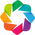

In [27]:
import geoviews as gv
import geopandas as gpd
import geoviews.feature as gf
import xarray as xr
from cartopy import crs

gv.extension('bokeh')

In [28]:
sf = gpd.read_file('../Données/france-circonscriptions-legislatives-2012.json')
sf.head() 

,ID,code_dpt,nom_dpt,nom_reg,num_circ,code_reg,geometry
0,33004,33,GIRONDE,AQUITAINE-LIMOUSIN-POITOU-CHARENTES,4,75,"POLYGON ((-0.45495 44.95342, -0.40932 44.94761..."
1,38001,38,ISERE,AUVERGNE-RHONE-ALPES,1,84,"POLYGON ((5.80529 45.20620, 5.75468 45.19679, ..."
2,59010,59,NORD,NORD-PAS-DE-CALAIS-PICARDIE,10,32,"POLYGON ((3.05875 50.78071, 3.08067 50.77286, ..."
3,33007,33,GIRONDE,AQUITAINE-LIMOUSIN-POITOU-CHARENTES,7,75,"POLYGON ((-0.61065 44.82247, -0.60305 44.81848..."
4,ZA001,ZA,GUADELOUPE,GUADELOUPE,1,01,"MULTIPOLYGON (((-61.49348 16.35364, -61.45097 ..."


On procède à quelques nettoyages supplémentaires sur les noms de département dans les deux tables afin d'uniformiser les styles d'écriture (pas d'accent, minuscules).

In [29]:
df2 = df_work.copy() 
# On travaille sur une copie de la table de travail pour ne pas la modifier.

df2["nom_circo"] = df2["nom_circo"].map(lambda x: remove_accent(x))
df2["nom_circo"] = df2["nom_circo"].str.lower()
sf["nom_dpt"] = sf["nom_dpt"].str.lower()

On exclut les départements d'outre-mer de notre étude, car il apparaît évident que leurs semaines de présence sont très faibles en raison de l'éloignement géographique. On s'intéresse donc exclusivement à la métropole ici.

In [30]:
sf = sf.loc[-sf['code_dpt'].isin(['ZA','ZB','ZC','ZD',
                                'ZM','ZN','ZS','ZX','ZW','ZP'])]
# On ne garde que les lignes correspondant aux circonscriptions métropolitaines.

Avant de pouvoir joindre nos deux tables, nous concaténons le numéro de circonscription et le département associé dans les deux bases de façon à obtenir une variable d'identification commune.

In [31]:
sf["id_circo"] = sf['num_circ'] + ' ' + sf['nom_dpt']

df2["id_circo"]=0
for i in range(len(df2)) :
    df2["id_circo"][i] = str(df2['num_circo'][i]) + ' ' + df2['nom_circo'][i]

In [32]:
# On réalise la jointure sur la nouvelle variable id_circo. 
jf = sf.merge(df2, how='left', left_on='id_circo', right_on='id_circo')

On peut désormais représenter les semaines de présence des députés en fonction de leur circonscription. Les circonscriptions grisées sur la carte ci-dessous correspondent à celles pour lesquelles nous n'avons pas de données sur l'activité du député. 

In [33]:
from geoviews import dim
circo = gv.Polygons(jf, vdims=['id_circo', 'semaines_presence'])
circo.opts(width=600, height=600, toolbar='above', color=dim('semaines_presence'), 
             colorbar=True, tools=['hover'], aspect='equal')

:Polygons   [Longitude,Latitude]   (id_circo,semaines_presence)

La lecture de cette carte ne permet pas de dégager de lien particulier entre l'origine géographique et la présence à l'Assemblée. Il existe des députés ruraux très présents et d'autres très peu assidus, il en va de même pour les députés urbains. 

De manière générale, l'analyse descriptive de nos données reste très insuffisante pour répondre à la problématique initiale, bien que les boxplots aient permis de dégager certaines tendances. 

## III. Modélisation

### 3.1 Liens entre les différentes variables d'assiduité

Nous avons jusqu'à présent étudié uniquement le nombre de semaines de présence des députés sur les bancs de l'Assemblée, sans nous préoccuper des autres indicateurs d'assiduité. Nous allons nous demander dans quelle mesure la présence est suffisante pour révéler l'assiduité, notamment en étudiant les corrélations entre les différents indicateurs.

Les indicateurs d'assiduité que nous avons à disposition sont 'semaines_presence', 'commission_presences', 'commission_interventions', 'hemicycle_interventions','hemicycle_interventions_courtes', 'amendements_proposes', 'amendements_signes', 'amendements_adoptes', 'rapports', 'propositions_ecrites', 'propositions_signees','questions_ecrites' et 'questions_orales'.

In [34]:
# On trace la matrice des nuages de points afin de percevoir les premiers liens entre les variables d'assiduité.
sns.set(font_scale=0.3)
sns.pairplot(df_work[['semaines_presence', 'commission_presences', 'commission_interventions', 'hemicycle_interventions','hemicycle_interventions_courtes', 'amendements_proposes', 'amendements_signes', 'amendements_adoptes', 'rapports', 'propositions_ecrites', 'propositions_signees','questions_ecrites', 'questions_orales']], height=0.6, markers=".", aspect=1.1)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

On constate de nombreuses corrélations entre les variables, cependant la variable donnant les semaines de présence semble par exemple assez décorrélée avec le nombre de questions écrites. Il faut donc prendre en compte un nombre plus élevé de variables pour dégager correctement l'assiduité des députés.

Nous allons commencer par regrouper les députés en groupes relativement homogènes (clusters) selon l'ensemble des variables d'assiduité.

### 3.2 Normalisation des données

Afin d'éviter que des variables l'emportent sur d'autres par des effets d'échelle, nous allons normaliser (centrer et réduire) les variables sur lesquelles nous obtiendrons les clusters.


In [35]:
# On crée une nouvelle table avec le numéro du député en index et les variables d'assiduité.
df_clusters = df_work[['semaines_presence', 'commission_presences', 'commission_interventions', 'hemicycle_interventions','hemicycle_interventions_courtes', 'amendements_proposes', 'amendements_signes', 'amendements_adoptes', 'rapports', 'propositions_ecrites', 'propositions_signees','questions_ecrites', 'questions_orales']]

In [36]:
import sklearn # On importe scikit-learn.
# On centre et réduit les variables de manière à effectuer une ACP normée.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
Z = sc.fit_transform(df_clusters)
Z

array([[-4.99136041e-01, -1.17818822e+00, -4.25038063e-01, ...,
        -6.82286754e-01,  2.36772151e+00,  6.48408303e-01],
       [-7.86259121e-01, -7.67223361e-01, -4.76110854e-01, ...,
        -5.05906629e-01,  1.23583513e+00, -6.12158245e-01],
       [ 6.49356279e-01, -6.13111538e-01, -4.42062327e-01, ...,
        -5.05906629e-01, -4.61994440e-01, -9.27299882e-01],
       ...,
       [-4.99136041e-01, -4.07629108e-01,  5.68528285e-04, ...,
         7.28754245e-01,  1.42448286e+00,  3.33266666e-01],
       [ 3.62233199e-01,  1.57447577e-01,  1.36762638e-01, ...,
         2.13979524e+00, -7.13524747e-01,  1.27869158e+00],
       [-2.93968222e+00, -1.69189430e+00, -5.78256436e-01, ...,
         2.13979524e+00,  9.84304822e-01, -9.27299882e-01]])

On vérifie que les moyennes sont nulles et les écarts-types unitaires ; c'est bien le cas : la normalisation a bien été effectuée.

In [37]:
print(np.mean(Z, axis=0))
print(np.std(Z, axis=0, ddof=0))

[-6.09695761e-17 -6.59130553e-17  3.13087013e-17 -4.44913123e-17
  3.29565276e-18  0.00000000e+00 -3.29565276e-17  9.22782774e-17
 -2.22456562e-17  4.94347914e-17  7.90956663e-17  3.95478332e-17
  0.00000000e+00]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### 3.3 Clustering

Afin de déterminer des groupes de députés en fonction de leur assiduité, on va désormais procéder à un clustering, en s'appuyant sur la méthode des k-moyennes (k-means), très répandue en partitionnement des données. Cette étape va nous permettre de constituer des groupes de députés d'assiduité comparable ; nous dégagerons ensuite les caractéristiques partagées par les députés appartenant au même cluster.

In [38]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score # On importe la métrique "silhouette" qui nous servira à déterminer le nombre de clusters optimal. 

In [39]:
# On applique la méthode des k-means sur les variables d'assiduité centrées et réduites, en supposant pour l'instant par défaut qu'il existe 3 clusters.
kmeans = KMeans(n_clusters=3, random_state=146355805) 
# random_state est la graine aléatoire specifiée pour rendre les résultats reproductibles.
kmeans.fit(Z)

# On trie les index en fonction des différents groupes de députés (ie des clusters).
idk = np.argsort(kmeans.labels_)

# Affichage des observations et leurs groupes
print(pd.DataFrame({"député" : df_clusters.index[idk], "cluster" : kmeans.labels_[idk]}))

     député  cluster
0       383        0
1       205        0
2        12        0
3       534        0
4       113        0
5       324        0
6        69        0
7       190        0
8       150        0
9       116        0
10      470        0
11      515        0
12      526        0
13      396        0
14      517        0
15      274        0
16      207        0
17      478        0
18      300        0
19       31        0
20       65        0
21      374        0
22      410        0
23      414        0
24       85        0
25      151        0
26      208        0
27      504        0
28      137        0
29      145        0
..      ...      ...
509     256        1
510     507        1
511     189        1
512      29        1
513     471        1
514     514        1
515     258        1
516     434        1
517     203        1
518     533        1
519     397        1
520     415        1
521     239        1
522     385        1
523     288        1
524     146  

On s'intéresse désormais à la répartition des députés au sein des différents clusters. 

In [40]:
nb_clusters = kmeans.labels_.tolist()
print(nb_clusters.count(0)) # Comptage du nombre de députés dans le cluster 1.
print(nb_clusters.count(1)) # Comptage du nombre de députés dans le cluster 2.
print(nb_clusters.count(2)) # Comptage du nombre de députés dans le cluster 3.

422
109
8


On observe que l'un des clusters, restreint à 8 observations, semble contenir des députés très marginalisés, dont nous analyserons plus tard les caractéristiques.
Vérifions tout d'abord le nombre optimal de clusters en s'appuyant sur la métrique "silhouette" : celle-ci évalue grâce à un coefficient (compris entre -1 et 1) propre à chaque point la différence entre la distance moyenne de ce point avec les points du même cluster et la distance moyenne de ce même point avec les points des autres clusters. Si le point est bien placé, il doit donc être plus proche en moyenne des points de son cluster ; ceci se matérialise par un coefficient de silhouette proche de 1. A l'inverse, un coefficient proche de -1 témoigne d'un mauvais partitionnement. On va donc tracer le score moyen de silhouette en fonction du nombre de clusters, et retenir le nombre de clusters correspondant au score maximal.

In [41]:
# On va faire varier le nombre de clusters dans un intervalle réaliste, disons de 2 à 10.
res = np.arange(9, dtype="double")
for k in np.arange(9):
    km = KMeans(n_clusters=k+2)
    km.fit(Z)
    res[k] = silhouette_score(Z, km.labels_)
print(res)

[0.39121398 0.38513749 0.15653107 0.16613427 0.18200082 0.19744827
 0.204173   0.18936514 0.20360326]


In [42]:
plt.figure(figsize=(8,4))
plt.plot(np.arange(2,11,1), res)
plt.title("Coefficient de silhouette moyen en fonction du nombre de clusters", size=16)
plt.xlabel("Nombre de clusters", size=10)
plt.ylabel("Score de silhouette moyen", size=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

A la vue de ce graphique, le choix optimal semble se porter sur 2 clusters (3 clusters ne semble pas être un mauvais choix non plus). Interprétons ceux-ci au moyen d'une analyse en composantes principales (ACP).

### 3.4 Analyse en Composantes Principales

Les données étant centrées et réduites, nous pouvons débuter l'ACP.

In [43]:
from sklearn.decomposition import PCA
# Instanciation de l'objet PCA
acp = PCA(svd_solver='full')

On remarque que le nombre de composantes n'est pas spécifié, il correspond donc par défaut au nombre de variables, à savoir 13 (ce qu'on vérifie dans la cellule suivante). Nous stockons maintenant les coordonnées factorielles dans la variable coord grâce à la fonction fit_transform().

In [44]:
# Calcul des coordonnées factorielles
coord = acp.fit_transform(Z)
# Vérification du nombre de composantes principales
print(acp.n_components_)

13


Désormais, nous allons afficher le pourcentage de la variance expliquée par chaque axe factoriel.

In [45]:
print(acp.explained_variance_ratio_)

[0.30292818 0.16774724 0.10467894 0.07784485 0.07354728 0.06130974
 0.0578616  0.04991936 0.03846265 0.02819897 0.01826355 0.01285006
 0.00638759]


On remarque que le premier axe explique environ 30% de l'information disponible, et les trois premiers près de 57 % : les autres axes ne semblent à première vue pas complètement anecdotiques. Nous allons donc tracer l'éboulis des valeurs propres (qui correspondent aussi à la variance expliquée par chaque axe) afin d'appliquer la méthode dite du coude. 

In [46]:
plt.figure(figsize=(8,4))
plt.bar(np.arange(1,acp.n_components_+1),acp.explained_variance_ratio_*100)
plt.title("Part de la variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Au vu du diagramme ci-dessus, nous allons choisir de garder les trois premières composantes factorielles (même si 4 composantes correspondraient mieux d'après la méthode du coude, nous choisissons 3 composantes pour des questions de représentation). Nous les représentons dans la figure en trois dimensions ci-dessous, avec une couleur différente pour chaque cluster trouvé à la section précédente.

In [47]:
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(111, projection='3d')
ax.set_xlim(-5,8)
ax.set_ylim(-5,8)
ax.set_zlim(-5,8)

for i in range(len(coord[:,0])):
    if kmeans.labels_[i] == 0:
        ax.text(coord[i,0], coord[i,1], coord[i,2], str(df_clusters.index[i]), size=6, color='r')
    elif kmeans.labels_[i] == 1:
        ax.text(coord[i,0], coord[i,1], coord[i,2], str(df_clusters.index[i]), size=6, color='g')
    else:
        ax.text(coord[i,0], coord[i,1], coord[i,2], str(df_clusters.index[i]), size=6, color='b')

ax.scatter(coord[:,0], coord[:,1], coord[:,2])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Nous pouvons constater que le nuage de points se compose de deux groupes : l'un quasiment aplati dans le plan (Oxy), qui est le premier plan factoriel, l'autre ayant des cotes elevées. Le cluster des 8 députés se distingue largement en constituant le second groupe ; les deux autres clusters semblent regroupés dans le plan (Oxy).

On constate néanmoins que les députés du petit cluster écrasent l'information donnée par les autres députés. Afin d'analyser plus finement les différents types de députés, nous allons retirer ces députés de notre étude après avoir interprété leur type.

Ces derniers députés se distinguant des autres par une cote élevée, interprétons les différents axes de l'ACP. On calcule pour cela les corrélations des variables avec chaque axe factoriel.

In [48]:
n = len(df_clusters)
p = len(df_clusters.columns)

eigval = (n-1)/n*acp.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp.components_[k,:] * sqrt_eigval[k]

print(pd.DataFrame({'Variable':df_clusters.columns,'Cor_axe_1':corvar[:,0],'Cor_axe_2':corvar[:,1], 'Cor_axe_3':corvar[:,2]}))

                           Variable  Cor_axe_1  Cor_axe_2  Cor_axe_3
0                 semaines_presence   0.557067   0.600929  -0.191771
1              commission_presences   0.425776   0.662578  -0.302692
2          commission_interventions   0.496364   0.325125  -0.420058
3           hemicycle_interventions   0.648652   0.488061   0.485997
4   hemicycle_interventions_courtes   0.399350   0.453602   0.745994
5              amendements_proposes   0.695054  -0.235665  -0.117199
6                amendements_signes   0.763213  -0.375204  -0.062249
7               amendements_adoptes  -0.428367   0.497853  -0.223568
8                          rapports   0.027278   0.174714  -0.383634
9              propositions_ecrites   0.495685  -0.237651   0.004301
10             propositions_signees   0.587427  -0.415955   0.040091
11                questions_ecrites   0.497084  -0.334478   0.013451
12                 questions_orales   0.729486  -0.121882  -0.216111


Puis on représente ces corrélations sur la sphère unité de $\mathbb{R}^3$.

In [49]:
r = 1
pi = np.pi
cos = np.cos
sin = np.sin
phi, theta = np.mgrid[0.0:pi:100j, 0.0:2.0*pi:100j]
x = r*sin(phi)*cos(theta)
y = r*sin(phi)*sin(theta)
z = r*cos(phi)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(x, y, z,  rstride=1, cstride=1, color='c', alpha=0.1, linewidth=0)

ax.add_line(plt3d.art3d.Line3D([-1,1], [0,0], [0,0]))
ax.add_artist(plt3d.art3d.Text3D(x=1, y=0, z=0, text='Axe 1', zdir='x', size=8))

ax.add_line(plt3d.art3d.Line3D([0,0], [-1,1], [0,0]))
ax.add_artist(plt3d.art3d.Text3D(x=0, y=1, z=0, text='Axe 2', zdir='y', size=8))

ax.add_line(plt3d.art3d.Line3D([0,0], [0,0], [-1,1]))
ax.add_artist(plt3d.art3d.Text3D(x=0, y=0, z=1, text='Axe 3', zdir='z', size=8))

ax.quiver(np.zeros(p), np.zeros(p), np.zeros(p), corvar[:,0], corvar[:,1], corvar[:,2], color='r')
for i in range(p):
    ax.add_artist(plt3d.art3d.Text3D(x=corvar[i,0], y=corvar[i,1], z=corvar[i,2], text=df_clusters.columns[i], zdir=(corvar[i,0], corvar[i,1], corvar[i,2]), size=6))


ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
ax.set_zlim([-1,1])

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

On constate que le troisième axe différencie essentiellement les députés effectuant de nombreuses interventions (courtes ou non) dans l'hémicycle. Le groupe de députés se situant dans le groupe du haut sur le nuage de point est donc celui des députés les plus actifs en séance.

Retirons les et recommençons le clustering et l'ACP.

### 3.5 Affinage de l'analyse

In [50]:
df_clusters2 = df_clusters.drop(df_clusters.index[kmeans.labels_ == 2])
Z2 = sc.fit_transform(df_clusters2)

In [51]:
res = np.arange(9, dtype="double")
for k in np.arange(9):
    km = KMeans(n_clusters=k+2)
    km.fit(Z2)
    res[k] = silhouette_score(Z2, km.labels_)

plt.figure(figsize=(8,4))
plt.plot(np.arange(2,11,1), res)
plt.title("Coefficient de silhouette moyen en fonction du nombre de clusters", size=16)
plt.xlabel("Nombre de clusters", size=10)
plt.ylabel("Score de silhouette moyen", size=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Cette fois-ci, le nombre de clusters optimal est clairement 2.

In [52]:
kmeans2 = KMeans(n_clusters=2, random_state=3535864)
kmeans2.fit(Z2)
idk = np.argsort(kmeans2.labels_)
print(pd.DataFrame({"député" : df_clusters2.index[idk], "cluster" : kmeans2.labels_[idk]}))
nb_clusters2 = kmeans2.labels_.tolist()
print(nb_clusters2.count(0)) # Comptage du nombre de députés dans le cluster 1.
print(nb_clusters2.count(1)) # Comptage du nombre de députés dans le cluster 2.

     député  cluster
0       383        0
1       238        0
2       137        0
3       504        0
4       208        0
5       526        0
6       205        0
7        12        0
8       534        0
9       113        0
10      324        0
11       69        0
12      190        0
13      150        0
14      116        0
15      470        0
16      515        0
17      396        0
18      151        0
19      517        0
20      274        0
21      207        0
22      478        0
23      261        0
24      531        0
25      300        0
26      100        0
27      114        0
28      447        0
29      333        0
..      ...      ...
501     112        1
502     124        1
503      15        1
504      68        1
505     283        1
506     415        1
507     493        1
508     514        1
509     120        1
510     434        1
511     111        1
512     373        1
513      32        1
514     455        1
515     502        1
516     409  

Nous avons là encore un cluster plus petit que l'autre, mais d'une taille nettement plus significative.

In [53]:
acp2 = PCA(svd_solver='full')
coord2 = acp2.fit_transform(Z2)
plt.figure(figsize=(8,4))
plt.bar(np.arange(1, acp2.n_components_+1), acp2.explained_variance_ratio_*100)
plt.title("Part de la variance expliquée par chaque axe factoriel", size=16, fontweight='bold')
plt.ylabel("Variance expliquée par l'axe factoriel (en %)", size=10)
plt.xlabel("Axe factoriel", size=10)
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Les deux premiers axes expliquent maintenant 50% de la variance à eux seuls.

Représentons les observations par cluster dans le premier plan factoriel. 

In [54]:
fig, axes = plt.subplots(figsize=(10,6))
axes.set_xlim(-5,10)
axes.set_ylim(-5,10)

for i in range(len(coord2[:,0])):
    if kmeans2.labels_[i] == 0:
        axes.text(coord2[i,0], coord2[i,1], str(df_clusters2.index[i]), size=6, color='r')
    else :
        axes.text(coord2[i,0], coord2[i,1], str(df_clusters2.index[i]), size=6, color='g')

axes.scatter(coord2[:,0], coord2[:,1])
plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

On remarque que les députés du cluster de gauche (en rouge) se distinguent essentiellement des députés du cluster de droite (en vert) par leur abscisse, c'est-à-dire par leur coordonnée sur leur premier axe factoriel. Nous allons donc maintenant calculer la corrélation des variables avec les deux premiers axes factoriels puis tracer le cercle des corrélations afin d'interpréter ces deux axes. 

In [55]:
n = len(df_clusters2)
p = len(df_clusters2.columns)

eigval = (n-1)/n*acp2.explained_variance_
sqrt_eigval = np.sqrt(eigval)
corvar = np.zeros((p,p))
for k in range(p):
    corvar[:,k] = acp2.components_[k,:] * sqrt_eigval[k]

print(pd.DataFrame({'Variable':df_clusters2.columns,'Cor_axe_1':corvar[:,0],'Cor_axe_2':corvar[:,1]}))

                           Variable  Cor_axe_1  Cor_axe_2
0                 semaines_presence   0.552689   0.605856
1              commission_presences   0.413833   0.690726
2          commission_interventions   0.567610   0.424653
3           hemicycle_interventions   0.817380   0.262870
4   hemicycle_interventions_courtes   0.684536   0.172765
5              amendements_proposes   0.715332  -0.193385
6                amendements_signes   0.760858  -0.365307
7               amendements_adoptes  -0.415093   0.544406
8                          rapports   0.054197   0.260701
9              propositions_ecrites   0.460106  -0.260975
10             propositions_signees   0.550433  -0.453888
11                questions_ecrites   0.473171  -0.351876
12                 questions_orales   0.769974  -0.039379


In [56]:
fig, axes = plt.subplots(figsize=(8,8))
axes.set_xlim(-1.05,1.05)
axes.set_ylim(-1.05,1.05)

for j in range(p):
    axes.arrow(0, 0, corvar[j,0], corvar[j,1], head_width=0.005, head_length=0.01, fc='grey', ec='grey')
    plt.annotate(df_clusters2.columns[j], (corvar[j,0],corvar[j,1]), size=8, color='r')

plt.plot([-1,1],[0,0],color='silver',linestyle='-',linewidth=1)
plt.plot([0,0],[-1,1],color='silver',linestyle='-',linewidth=1)

cercle = plt.Circle((0,0), 1, color='blue', fill=False)
axes.add_artist(cercle)

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

L'immense majorité des variables d'assiduité semblent très fortement corrélées avec le premier axe factoriel (à l'exception des rapports et des amendements adoptés), alors que le deuxième axe factoriel ne semble pas vraiment rendre compte de l'assiduité des députés. On va donc s'intéresser en particulier aux députés présentant une coordonnée élevée selon le premier axe factoriel. 

On va commencer par étudier les caractéristiques des députés de chacun des deux clusters afin de dégager des tendances claires quant aux facteurs pouvant expliquer l'assiduité supérieure des députés du cluster vert par rapport à celle des députés du cluster rouge. Pour ce faire, on scinde notre table de travail en deux sous-tables contenant chacune les députés de l'un des deux clusters.

In [57]:
A = pd.DataFrame({"député" : df_clusters2.index[idk], "cluster" : kmeans2.labels_[idk]})
R = [] # Liste qui contiendra les index des députés du cluster rouge.
V = [] # Liste qui contiendra les index des députés du cluster vert.
for i in range(len(A)) :
    if A['cluster'][i] == 0 :
        R.append(A['député'][i])
    else : 
        V.append(A['député'][i])
# On vérifie qu'il y a bien 437 éléments dans la liste R et 94 dans la liste R.
len(R), len(V) 

(437, 94)

In [58]:
df_cluster_rouge = df_work.loc[R] # Sous-table avec les députés du cluster rouge.
df_cluster_vert = df_work.loc[V] # Sous-table avec les députés du cluster vert.

On va maintenant comparer les statistiques obtenues sur les variables dans les deux cas. Commençons par les variables quantitatives. 

In [59]:
df_cluster_rouge.describe()

,num_circo,nb_mandats,semaines_presence,commission_presences,commission_interventions,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales,age
count,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000,437.000000
mean,4.590389,1.260870,25.066362,34.926773,22.485126,39.993135,25.681922,57.013730,920.439359,162.464531,0.109840,0.105263,4.363844,13.473684,1.945080,51.855835
std,3.593342,0.460008,6.477745,17.963371,40.759058,55.352146,59.534640,95.201307,792.468492,75.542210,0.373207,0.392469,3.405725,14.442304,1.881027,11.215970
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000
25%,2.000000,1.000000,21.000000,22.000000,4.000000,8.000000,2.000000,12.000000,482.000000,137.000000,0.000000,0.000000,3.000000,2.000000,1.000000,44.000000
50%,3.000000,1.000000,26.000000,32.000000,12.000000,20.000000,6.000000,29.000000,646.000000,174.000000,0.000000,0.000000,4.000000,9.000000,2.000000,52.000000
75%,6.000000,2.000000,29.000000,46.000000,23.000000,47.000000,20.000000,68.000000,989.000000,211.000000,0.000000,0.000000,5.000000,19.000000,3.000000,60.000000
max,21.000000,3.000000,42.000000,102.000000,376.000000,403.000000,546.000000,873.000000,4683.000000,503.000000,3.000000,3.000000,32.000000,64.000000,12.000000,82.000000


In [60]:
df_cluster_vert.describe()

,num_circo,nb_mandats,semaines_presence,commission_presences,commission_interventions,hemicycle_interventions,hemicycle_interventions_courtes,amendements_proposes,amendements_signes,amendements_adoptes,rapports,propositions_ecrites,propositions_signees,questions_ecrites,questions_orales,age
count,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000,94.000000
mean,4.563830,1.340426,31.882979,49.553191,86.255319,230.787234,219.819149,850.936170,3552.723404,90.127660,0.106383,0.808511,12.765957,29.734043,7.670213,52.819149
std,3.800279,0.539876,5.407793,20.528824,90.582575,165.031432,243.734298,957.109389,1567.971934,49.373981,0.309980,1.175709,8.345272,16.024964,3.759971,10.832014
min,1.000000,1.000000,16.000000,9.000000,3.000000,8.000000,5.000000,11.000000,514.000000,19.000000,0.000000,0.000000,1.000000,0.000000,0.000000,29.000000
25%,2.000000,1.000000,28.250000,34.000000,31.250000,114.250000,54.250000,156.500000,2517.500000,44.250000,0.000000,0.000000,7.000000,15.000000,5.000000,45.500000
50%,4.000000,1.000000,32.000000,45.000000,56.000000,175.500000,153.500000,416.500000,3465.500000,83.000000,0.000000,0.000000,11.000000,31.500000,7.000000,54.000000
75%,6.000000,2.000000,35.000000,62.250000,96.000000,320.000000,293.750000,1027.000000,5262.500000,120.750000,0.000000,1.000000,16.750000,41.750000,9.750000,61.000000
max,20.000000,3.000000,43.000000,111.000000,500.000000,708.000000,1531.000000,2887.000000,7434.000000,213.000000,1.000000,6.000000,37.000000,53.000000,18.000000,78.000000


Nous constatons que les députés du cluster vert ont bel et bien une assiduité très supérieure à leurs homologues du cluster rouge : les valeurs moyennes et médianes pour les variables de présence ou de participation sont bien plus élevées dans leur cas. La segmentation précédemment effectuée est donc pertinente. 
En revanche, l'âge ne semble pas avoir d'influence sur cette assiduité : les deux distributions semblent se superposer. Enfin, contre toute attente, cumuler des mandats n'est pas un facteur d'absentéisme ou d'inactivité ; au contraire, les députés les plus assidus ont en moyenne davantage de mandats que les autres, même si cette différence est très légère. 

Intéressons-nous désormais aux variables qualitatives, à commencer par le sexe des députés.

In [61]:
display(pd.DataFrame({'Nb dans cluster rouge' : df_cluster_rouge['sexe'].value_counts(), 'Prop dans cluster rouge' : df_cluster_rouge['sexe'].value_counts(normalize=True)})) # Répartition des femmes et des hommes dans le cluster rouge.
display(pd.DataFrame({'Nb dans cluster vert' : df_cluster_vert['sexe'].value_counts(), 'Prop dans cluster vert' : df_cluster_vert['sexe'].value_counts(normalize=True)})) # Répartition des femmes et des hommes dans le cluster vert.

,Nb dans cluster rouge,Prop dans cluster rouge
H,255,0.583524
F,182,0.416476


,Nb dans cluster vert,Prop dans cluster vert
H,63,0.670213
F,31,0.329787


On remarque que les femmes sont moins représentées en pourcentage dans le cluster vert, autrement dit celui des députés assidus. Cette tendance apparaissait déjà lors de l'analyse descriptive à laquelle nous avons procédé précédemment.

Voyons désormais si les différents partis politiques sont représentés de la même manière dans les deux clusters. 

In [62]:
display(pd.DataFrame({'Nb dans cluster rouge' : df_cluster_rouge['groupe_sigle'].value_counts(), 'Prop dans cluster rouge' : df_cluster_rouge['groupe_sigle'].value_counts(normalize=True)})) 
display(pd.DataFrame({'Nb dans cluster vert' : df_cluster_vert['groupe_sigle'].value_counts(), 'Prop dans cluster vert' : df_cluster_vert['groupe_sigle'].value_counts(normalize=True)}))

,Nb dans cluster rouge,Prop dans cluster rouge
LREM,255,0.583524
LR,54,0.123570
MODEM,51,0.116705
NI,23,0.052632
AE,17,0.038902
SOC,12,0.027460
LT,11,0.025172
UDI,11,0.025172
GDR,3,0.006865


,Nb dans cluster vert,Prop dans cluster vert
LR,36,0.382979
LFI,17,0.180851
SOC,12,0.127660
GDR,12,0.127660
LT,7,0.074468
UDI,5,0.053191
MODEM,2,0.021277
AE,2,0.021277
NI,1,0.010638


On remarque ici que les députés de la majorité LREM-MODEM sont intégralement dans le cluster des députés les moins assidus, à l'exception de deux députés du MODEM. A l'inverse, les députés de gauche, en particulier du GDR (Groupe de la Gauche démocrate et républicaine) et du groupe LFI (La France insoumise), se distinguent par une présence quasi-exclusive au sein du groupe de députés assidus (ici le cluster vert).

Si l'âge ne semble pas corrélé avec l'assiduité, il apparaît que le sexe et l'appartenance politique le sont davantage : les hommes et les parlementaires de gauche sont globalement plus assidus que les femmes et les parlementaires de la majorité.

Une dernière variable qualitative, le statut des députés, est suceptible d'expliquer l'assiduité. On peut en effet penser a priori que les habitués et les nouveaux élus ne fréquentent pas les bancs de l'hémicycle de la même manière, ni à la même régularité.

In [63]:
display(pd.DataFrame({'Nb dans cluster rouge' : df_cluster_rouge['Statut'].value_counts(), 'Prop dans cluster rouge' : df_cluster_rouge['Statut'].value_counts(normalize=True)})) 
display(pd.DataFrame({'Nb dans cluster vert' : df_cluster_vert['Statut'].value_counts(), 'Prop dans cluster vert' : df_cluster_vert['Statut'].value_counts(normalize=True)}))

,Nb dans cluster rouge,Prop dans cluster rouge
elu pour la 1ere fois,331,0.757437
sortant,72,0.164760
arrive en cours de mandat,24,0.054920
ancien,10,0.022883


,Nb dans cluster vert,Prop dans cluster vert
elu pour la 1ere fois,53,0.563830
sortant,38,0.404255
ancien,2,0.021277
arrive en cours de mandat,1,0.010638


On constate en effet que les nouveaux élus et les sortants sont inégalement répartis dans nos deux clusters d'assiduité : les députés sortants sont près d'un tiers dans le cluster des assidus, tandis que les nouveaux élus sont pour immense majorité dans le cluster des moins assidus. Les députés arrivés en cours de mandat sont quant à eux le plus souvent peu assidus.

### 3.6 Modélisation linéaire et étude causale

Jusqu'à présent, notre segmentation des députés en deux groupes d'assiduité différente, puis notre analyse descriptive sur ces groupes, nous ont permis de dégager les grandes tendances décrivant le député assidu. Il est en général un homme, de gauche, qui le plus souvent occupait déjà sa fonction au mandat précédent.

On pourrait intuitivement inférer la cause de cette tendance au moyen d'éléments sociologiques généraux :
- les femmes passent moins de temps sur leur lieu de travail que les hommes du fait qu'elles prennent plus en charge les tâches domestiques que les hommes ;
- les députés de gauche forment un bloc d'opposition important au gouvernement, leur assiduité a de l'importance s'ils veulent faire entendre leur voix ;
- les députés sortants sont les plus habitués, ils sont suceptibles de fréquenter plus régulièrement l'Assemblée pour entretenir les liens qu'ils ont créés lors du précédent mandat.

Les explications ci-dessus ne sont cependant en aucun cas déduites de nos données : nous n'avons identifié que des corrélations et jamais d'effet causal. Afin d'essayer d'expliquer l'assiduité des députés grâce aux variables que nous avons à disposition, nous allons mettre en place un modèle linéaire.

Nous choisissons comme variable explicative la coordonnée des députés sur le premier axe factoriel : cette variable synthétise une grande part de l'information disponible sur l'assiduité et constitue donc un bon "score d'assiduité".

Nous allons effectuer nos régressions linéaires sur les données des députés des deux clusters principaux uniquement (sans les 8 députés très actifs en séance).

In [64]:
# On prépare le DataFrame pour les régressions linéaires.
df_reg = df_work.drop(df_work.index[kmeans.labels_ == 2])
df_reg["assiduite"] = coord2[:,0] # On ajoute notre score d'assiduité.

df_reg = df_reg.drop(['semaines_presence', 'commission_presences', 'commission_interventions', 'hemicycle_interventions','hemicycle_interventions_courtes', 'amendements_proposes', 'amendements_signes', 'amendements_adoptes', 'rapports', 'propositions_ecrites', 'propositions_signees','questions_ecrites', 'questions_orales', 'tranche_age'], axis=1) 
# On supprime les variables d'assiduité qui ne nous servent plus.
df_reg.head()

,nom,sexe,num_deptmt,nom_circo,num_circo,groupe_sigle,profession,nb_mandats,Statut,age,region,assiduite
383,ludovic pajot,H,62,Pas-de-Calais,10,NI,Aucune,1,elu pour la 1ere fois,26,Hauts-de-France,-0.207073
139,typhanie degois,F,73,Savoie,1,LREM,Juriste,1,elu pour la 1ere fois,27,Auvergne-Rhône-Alpes,-1.375591
235,pierre henriet,H,85,Vendée,5,LREM,Professeur du secondaire et technique,1,elu pour la 1ere fois,28,Pays de la Loire,-1.480353
3,lenaick adam,H,973,Guyane,2,LREM,Cadre supérieur (entreprises privée),1,elu pour la 1ere fois,28,Outre mer,-2.665537
375,mickael nogal,H,31,Haute-Garonne,4,LREM,Autre profession libérale,1,elu pour la 1ere fois,29,Occitanie,-1.303817


Commençons par étudier l'effet du sexe sur l'assiduité. Afin de minimiser le biais de variable omise, nous allons ajouter les variables de contrôle 'age' et 'region' qui sont susceptibles d'avoir un effet à la fois sur le sexe et l'assiduité. Nous ne contrôlons pas par 'groupe_sigle' ou 'profession' car ces variables sont potentiellement fonctions du sexe ; ceci afin de limiter le biais de variable incluse.

In [65]:
import statsmodels.formula.api as sm

# On va effectuer la régression linéaire du score d'assiduité sur le sexe, l'âge et la région d'origine des députés. 
model = sm.ols('assiduite ~ sexe + age + region', data = df_reg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              assiduite   R-squared:                       0.074
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.751
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           0.000424
Time:                        16:22:31   Log-Likelihood:                -1134.3
No. Observations:                 531   AIC:                             2301.
Df Residuals:                     515   BIC:                             2369.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Toutes choses égales par ailleurs dans cette régression, le fait d'être un homme augmente en moyenne le score d'assiduité de 0,4 points.
Le fait d'être un homme aurait donc un effet causal positif sur l'assiduité des députés. Cela confirmerait notre intuition de départ.

Poursuivons par l'étude de l'effet du parti sur l'assiduité. Cette fois, nous contrôlerons par les variables 'sexe', 'profession', 'age' et 'region' qui peuvent influencer à la fois l'assiduité et le parti. Nous ne contrôlerons pas par 'nb_mandats' et 'Statut' qui sont certainement des fonctions du parti.

In [66]:
#ATTENTION : IL FAUDRAIT ICI RECODER LA PROFESSION AVANT DE L'AJOUTER DANS LA RÉGRESSION

model = sm.ols('assiduite ~ groupe_sigle + sexe + age + region', data = df_reg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              assiduite   R-squared:                       0.631
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     36.12
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           1.22e-93
Time:                        16:22:31   Log-Likelihood:                -889.71
No. Observations:                 531   AIC:                             1829.
Df Residuals:                     506   BIC:                             1936.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Toutes choses égales par ailleurs dans cette régression, le fait d'appartenir au groupe LFI, GDR ou SOC augmente en moyenne le score d'assiduité de xx, xx ou xx points. Le fait d'appartenir à la majorité LREM ou MODEM diminue en moyenne ce score de xx ou xx points.
Globalement, on constate que les partis d'opposition ont des coefficients positifs, tandis que la majorité a ses deux coefficients négatifs.
Le fait d'appartenir à la majorité diminuerait donc bien l'assiduité comme nous l'avions prédit.

Pour finaliser l'étayement de nos intuitions, étudions maintenant l'impact du statut des députés sur leur assiduité. Nous contrôlerons par 'groupe_sigle', 'age' et 'region', les autres variables étant a priori sans lien avec le statut.

In [67]:
model = sm.ols('assiduite ~ Statut + groupe_sigle + age + region', data = df_reg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              assiduite   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     33.57
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           8.31e-93
Time:                        16:22:32   Log-Likelihood:                -887.90
No. Observations:                 531   AIC:                             1830.
Df Residuals:                     504   BIC:                             1945.
Df Model:                          26                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Nous remarquons cette fois que notre intuition de départ était erronée : les nouveaux élus semblent aussi assidus que les anciens. Cela s'explique par la constatation précédente : le fait d'être de la majorité entraîne une baisse d'assiduité ; or LREM comporte énormément de nouveux élus (car c'est un nouveau parti) ; il y avait donc un biais dans notre interprétation initiale.

Nous n'avons cependant pas encore regardé l'influence du nombre de mandats ou de la profession sur l'assiduité. Cela finalisera notre étude.

'nb_mandats' est susceptible d'être influencé par 'sexe', 'groupe_sigle', 'profession', 'Statut', 'age' et 'region' sans que ces variables soient des fonctions du nombre de mandats.

In [68]:
# AJOUTER PROFESSION LORSQUE LA VARIABLE SERA RECODÉE

model = sm.ols('assiduite ~ nb_mandats + sexe + groupe_sigle + Statut + age + region', data = df_reg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              assiduite   R-squared:                       0.634
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     31.07
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           2.54e-91
Time:                        16:22:32   Log-Likelihood:                -887.80
No. Observations:                 531   AIC:                             1834.
Df Residuals:                     502   BIC:                             1958.
Df Model:                          28                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


Étonnamment, le nombre de mandats ne semble avoir qu'un très faible impact sur l'assiduité des députés (valeur faible et coefficient non significatif).

Analysons enfin l'impact de la profession. Nous contrôlerons par le sexe et la région.

In [69]:
# AJOUTER PROFESSION APRÈS RECODAGE

model = sm.ols('assiduite ~ sexe + region', data = df_reg)
result = model.fit()
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:              assiduite   R-squared:                       0.072
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     2.881
Date:                Sun, 15 Nov 2020   Prob (F-statistic):           0.000330
Time:                        16:22:32   Log-Likelihood:                -1134.7
No. Observations:                 531   AIC:                             2299.
Df Residuals:                     516   BIC:                             2364.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------


* INTERPRÉTER LA REGRESSION SUR LA PROFESSION

## Conclusion

Notre étude nous a conduits à appréhender l'assiduité des députés sous un angle plus général que celui de la seule présence. Une analyse en composantes principales nous a permis de synthétiser l'activité des députés à l'Assemblée grâce à un nombre réduit de variables.

Par la suite, un clustering nous a permis d'identifier clairement deux catégories de députés ; même si cette segmentation n'est pas parfaite car il y a en réalité un continuum d'assiduité, nous avons bien pu obverver qu'un groupe de députés se distinguait de la masse par son activité.

Une analyse descriptive et comparative des deux clusters nous a permis de dégager les grandes tendances caractérisant les députés assidus.

Enfin, des régressions linéaires nous ont permis d'estimer l'effet causal de variables explicatives sur l'assiduité afin de déterminer plus précisément le profil du député assidu.

Finalement, selon notre étude, le député assidu est un homme de l'opposition (plus particulièrement de l'opposition de gauche, voire d'extrême gauche) (AYANT POUR PROFESSION ?)

Ce profilage nous apparaît crédible. Nous pourrions maintenant nous demander s'il s'agit là d'un fait d'époque, ou si le député assidu a toujours eu ce profil dans les législatures précédentes, et si oui, dans quelle mesure.